In [206]:
import uproot
import pandas as pd
import mplhep as hep
import numpy as np
import awkward
import ROOT
import scipy.stats as stats #this one used to do fits
import matplotlib.pyplot as plt
import awkward as ak
import MyHelpers as mh
from tqdm import tqdm #this is a fancy feature to make a progress bar as the loop proceed


#to make the plots in CMS style execute this line
plt.style.use([hep.style.ROOT, hep.style.firamath])
plt.style.use(hep.style.CMS)

In [207]:
#Getting files
#Execute this line if running on SWAN, otherwise update the path to the data files:
PATH='/eos/cms/store/user/jjhollar/CERNSummerStudentProject2021/'
#PATH='data'
filename=PATH+'/gammagammaMuMu_FPMC_pT25_14TeV_PU200_NTUPLE_jobs123merge_version4.root'
#load the file content
tree = uproot.open(filename+":myana/mytree")
tree.show()

filename=PATH+'DYMuMu_PU200_NTUPLE_1_version3.root'
bg_tree = uproot.open(filename+":myana/mytree")

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
evt_size             | int32_t                  | AsDtype('>i4')
vtx_size             | int32_t                  | AsDtype('>i4')
vtx_x                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_y                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_z                | float[]                  | AsJagged(AsDtype('>f4'))
vtx_pt2              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_size           | int32_t                  | AsDtype('>i4')
vtx4D_x              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_y              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_z              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_t              | float[]                  | AsJagged(AsDtype('>f4'))
vtx4D_terr           | float[]             

In [208]:
#Create signal tree
event_info = tree.arrays(['genvtx_t0']) 
muons = tree.arrays(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz'],'abs(pfcand_pid)==13') 
protons = tree.arrays(['genproton_xi','genproton_pz','genproton_vz','genproton_ispu'], '(genproton_ispu == 0) & (abs(genproton_pz)<6999) & (abs(genproton_pz)>0)')  
vertices = tree.arrays(['vtx4D_t','vtx4D_z','vtx4D_pt2']) 
#(abs(genproton_xi)> 0.0032) & 
#Create background tree
#Compressing the muon data
bg_muons =[]
for batch, report in bg_tree.iterate(['pfcand_pt','pfcand_eta','pfcand_phi','pfcand_mass','pfcand_t','pfcand_vz','pfcand_pid'], step_size=1000, report=True):
    #print(report)
    bg_muons.append(batch[(abs(batch.pfcand_pid)==13) & (batch.pfcand_pt>25)] )
bg_muons=ak.concatenate(bg_muons)

bg_protons = bg_tree.arrays(['genproton_xi','genproton_pz','genproton_vz','genproton_ispu'],'(abs(genproton_pz)<6999) & (abs(genproton_pz)>0)')
bg_event_info = bg_tree.arrays(['genvtx_t0']) 
bg_vertices = bg_tree.arrays(['vtx4D_t','vtx4D_z','vtx4D_pt2'])

In [210]:
sqrt_s = 14000
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns 

#define data array for signal
sig_data = {}
mh.InitData(sig_data)
#loop over all events for the signal
N = len(muons)
for i in tqdm(range(N)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=muons[i]
    mu1_idx, mu2_idx = mh.SelMu(mu)            
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue 
    mu1, mu2 = mh.GiveMu(mu, mu1_idx, mu2_idx)
    #exclude muons with dummy values
    if mu.pfcand_t[mu1_idx]<-80 or mu.pfcand_t[mu2_idx]<-80: continue
    xi_dimu_plus = ((mu1.Pt()*np.exp(mu1.Rapidity())+mu2.Pt()*np.exp(mu2.Rapidity())) / sqrt_s) 
    xi_dimu_minus =((mu1.Pt()*np.exp(-mu1.Rapidity())+mu2.Pt()*np.exp(-mu2.Rapidity())) / sqrt_s)
    #additional cut
    if((xi_dimu_plus<0.0032) == True & (xi_dimu_minus<0.0032) == True): continue   
    # find two signal protons:
    pr=protons[i]
    # smearing and selecting protons
    pr1_idx, pr2_idx = mh.SelProtons(pr,mu1,mu2, xi_dimu_plus, xi_dimu_minus)
    if pr1_idx<0 or pr2_idx<0: continue
    vx = vertices[i]
    ev = event_info[i]
    #Filling muon and proton events
    mh.Fill_mu(sig_data, mu, mu1, mu2, mu1_idx,mu2_idx)
    mh.Fill_pr(sig_data,pr,pr1_idx,pr2_idx,vx,ev)
    mh.Sig_time(sig_data, ev, pr, pr1_idx, pr2_idx)
    #Add smeared proton times
    mh.Fill_smeared_pr_t(sig_data)
sig = pd.DataFrame(data=sig_data)

#define data array for Background
bg_data = {}
mh.InitData(bg_data)
#loop over all events for the background
n = len(bg_muons)
for i in tqdm(range(n)): 
    #find index of two highest pT muons with pT > 25 GeV
    mu=bg_muons[i]
    mu1_idx, mu2_idx = mh.SelMu(mu)    
    #if found less than 2 muons, skip the event:
    if mu1_idx<0 or mu2_idx<0: continue 
    mu1, mu2 = mh.GiveMu(mu, mu1_idx, mu2_idx)
    #exclude muons with dummy values
    if mu.pfcand_t[mu1_idx]<-80 or mu.pfcand_t[mu2_idx]<-80: continue
    xi_dimu_plus = ((mu1.Pt()*np.exp(mu1.Rapidity())+mu2.Pt()*np.exp(mu2.Rapidity())) / sqrt_s) 
    xi_dimu_minus =((mu1.Pt()*np.exp(-mu1.Rapidity())+mu2.Pt()*np.exp(-mu2.Rapidity())) / sqrt_s)
    #additional cut
    if((xi_dimu_plus<0.0032) == True & (xi_dimu_minus<0.0032) == True): continue 
    # find two signal protons:
    pr=bg_protons[i]
    # smearing and selecting protons
    pr1_idx, pr2_idx = mh.SelProtons(pr,mu1,mu2, xi_dimu_plus, xi_dimu_minus)
    #if pr1_idx<0 or pr2_idx<0: continue
    vx = bg_vertices[i]
    ev = bg_event_info[i]
    #Filling muon and proton events
    mh.Fill_mu(bg_data,mu, mu1, mu2, mu1_idx,mu2_idx)
    mh.Fill_pr(bg_data,pr,pr1_idx,pr2_idx,vx,ev) 
    mh.Bg_time(bg_data, pr, pr1_idx, pr2_idx)
    #Add smeared proton times
    mh.Fill_smeared_pr_t(bg_data)
bg = pd.DataFrame(data=bg_data)

print(len(sig['mu1_pt']))

100%|██████████| 15296/15296 [00:50<00:00, 301.06it/s]


106


105


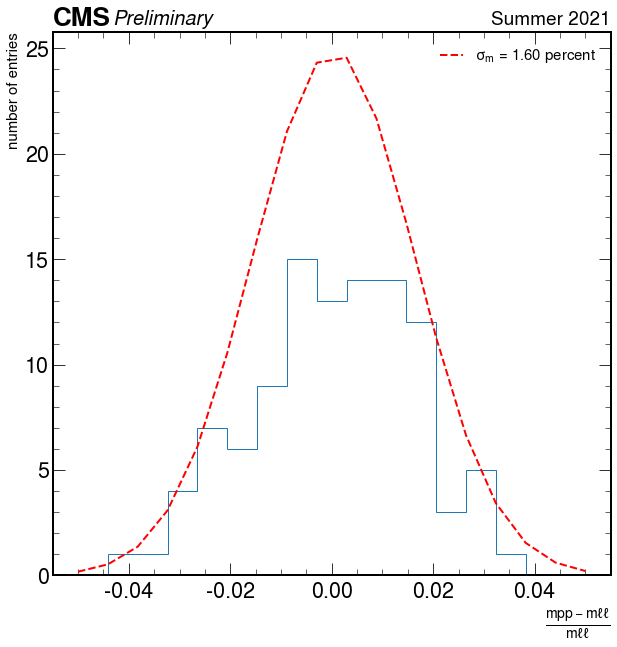

In [265]:
#You can plot mpp/mll-1 distribution, fit a gaussian and define a cut to be within the 2 sigma: |mpp-mll| < 2*sigma*mll
data = (sig['mpp'].values/sig['mll'].values)-1
#data = data[~np.isnan(data) & (abs(data) < 0.1)]
data = data[ abs(data) < 0.05]
#np.delete(data,max(data))
#data = data
print((len(data)))
bins = np.linspace(-0.05,0.05,18)
f, ax = plt.subplots()
plt.hist(data,bins, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu_m, sigma_m) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu_m, sigma_m)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{m}$ = %2.2f percent'%(sigma_m*100), )

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax, fontsize=20)
ax.set(xlabel=r'$ \frac{mpp - m\ell\ell}{m\ell\ell}$', ylabel='number of entries')
ax.legend(loc='upper right',fontsize=15)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(15)

plt.savefig('FinalResults/fit_mass_ratio.png',bbox_inches='tight')

86


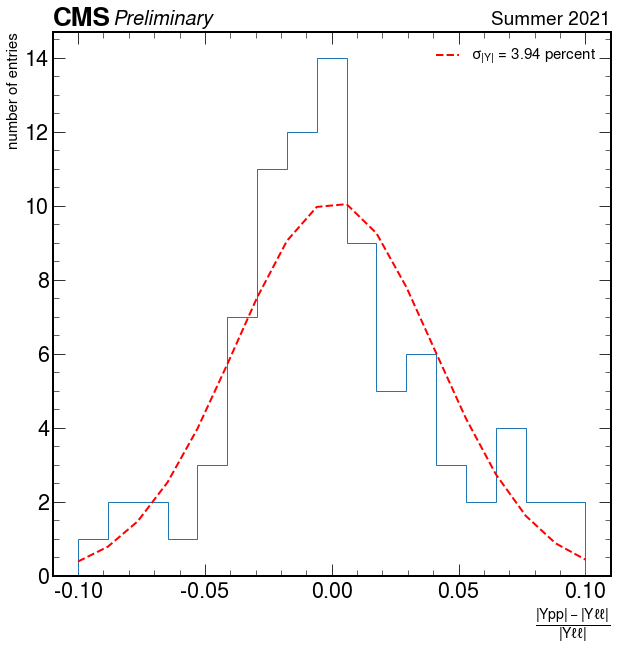

In [266]:
new_data = (sig['ypp'].values - sig['yll'].values)/abs(sig['yll'].values)

new_data = new_data[~np.isnan(new_data) &(abs(new_data) < 0.1) ]
#data = data[data <100]
#new_data = np.delete(data, np.where(data == np.max(data)) )
#new_data = np.delete(new_data,np.where(data == np.min(data)) )
print(len(new_data))
#bins = np.linspace(-1,1,100)
bins = np.linspace(-0.1,0.1,18)
f, ax = plt.subplots()
plt.hist(new_data,bins, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu_y, sigma_y) = stats.norm.fit(new_data)
x=bins
y=stats.norm.pdf(x, mu_y, sigma_y)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{|Y|}$ = %2.2f percent'%(sigma_y*100))

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax,fontsize=20)
ax.set(xlabel=r'$\frac{|Ypp| - |Y\ell \ell|}{|Y\ell \ell|}$', ylabel='number of entries')
ax.legend(loc='upper right',fontsize=15)
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(15)

plt.savefig('FinalResults/fit_eta_ratio.png',bbox_inches='tight')

acceptance rate from background mass:
0.03958509737510584
acceptance rate from signal mass:
0.9622641509433962


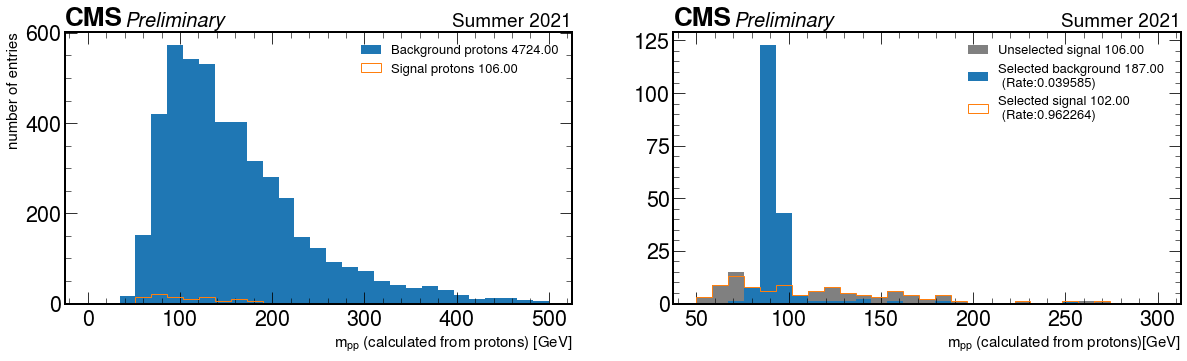

In [267]:
#criteria for selection: |mpp-mll|<2sigma*mll
b = []
data = abs(bg['mpp']-bg['mll']) 

for i in range(0,len(data)):
    if data[i] < abs(2*sigma_m*bg['mll'][i]):
        b = np.append(b,bg['mpp'][i])

m_acc_bg = len(b)/len(data)
print('acceptance rate from background mass:')
print(m_acc_bg)

s = []
data = abs(sig['mpp'] - sig['mll'])
for i in range(0,len(data)):
    if data[i] < abs(2*sigma_m*sig['mll'][i]):
        s = np.append(s, sig['mpp'][i])

m_acc_s = len(s)/len(data)
print('acceptance rate from signal mass:')
print(m_acc_s)

f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(0,500,30)
ax[0].hist(bg['mpp'],bins,label='Background protons %2.2f'%(len(bg['mpp'])))
ax[0].hist(sig['mpp'],bins,histtype='step', label='Signal protons %2.2f'%len(sig['mpp']))
ax[0].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]', ylabel='number of entries')
ax[0].legend()

bins = np.linspace(50,300,30)
ax[1].hist(sig['mpp'],bins,color='grey',label='Unselected signal %2.2f' %len(sig['mpp']))
ax[1].hist(b, bins,label='Selected background %2.2f \n (Rate:%6.6f)'%(len(b),m_acc_bg))
ax[1].hist(s, bins,histtype='step',label='Selected signal %2.2f \n (Rate:%6.6f)'%(len(s),m_acc_s))
ax[1].set(xlabel=r'$m_{pp}$ (calculated from protons)[GeV]')
#ax[1].legend(fontsize=15)
for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 20)
    ax[i].legend(fontsize=13)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('FinalResults/surviving_protons_mass',bbox_inches='tight')

acceptance rate from background eta:
0.04106689246401355
acceptance rate from signal eta:
0.7641509433962265
4724


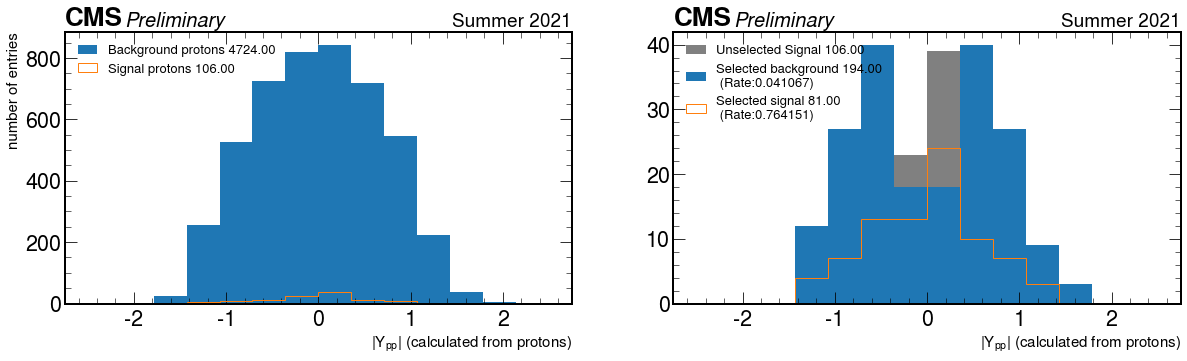

In [268]:
#criteria for selection: |ypp-yll|<2sigma*mll
b = []
data = abs(bg['ypp']-bg['yll'])

for i in range(0,len(data)):
    if data[i] < abs(2*sigma_y*bg['yll'][i]): #the abs has no impact for the background !
        b = np.append(b,bg['ypp'][i])
#print(len(b))
y_acc_bg = len(b)/len(data)
print('acceptance rate from background eta:')
print(y_acc_bg)

s = []
#print(len(analysis['s_yll']))
data = abs(sig['ypp'] - sig['yll'])
for i in range(0,len(data)):
    if data[i] < abs(2*sigma_y*sig['yll'][i]): #but if I leave it out here, I have 0 for the signal acceptance!
        s = np.append(s, sig['ypp'][i])
#print(len(s))
y_acc_s = len(s)/len(data)
print('acceptance rate from signal eta:')
print(y_acc_s)
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-2.5,2.5,15)
print(len(bg['ypp']))
ax[0].hist(bg['ypp'],bins,label='Background protons %2.2f'%(len(bg['ypp'])))
ax[0].hist(sig['ypp'], bins,histtype='step', label='Signal protons %2.2f' %len(sig['ypp']))
ax[0].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)', ylabel='number of entries')
binsb = np.linspace(-2.5,2.5,15)

ax[1].hist(sig['ypp'],binsb, color = 'grey', label='Unselected Signal %2.2f' %len(sig['ypp']))
ax[1].hist(b,binsb,label='Selected background %2.2f \n (Rate:%6.6f)'%(len(b),y_acc_bg))
ax[1].hist(s,binsb,histtype='step',label='Selected signal %2.2f \n (Rate:%6.6f)'%(len(s),y_acc_s))
ax[1].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 20)
    ax[i].legend(fontsize=13,loc= 'upper left')
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('FinalResults/surviving_protons_eta', bbox_inches='tight')

acceptance rate from combined background cut:
0.0035986452159187127
acceptance rate from combined signal cut:
0.7358490566037735
4724


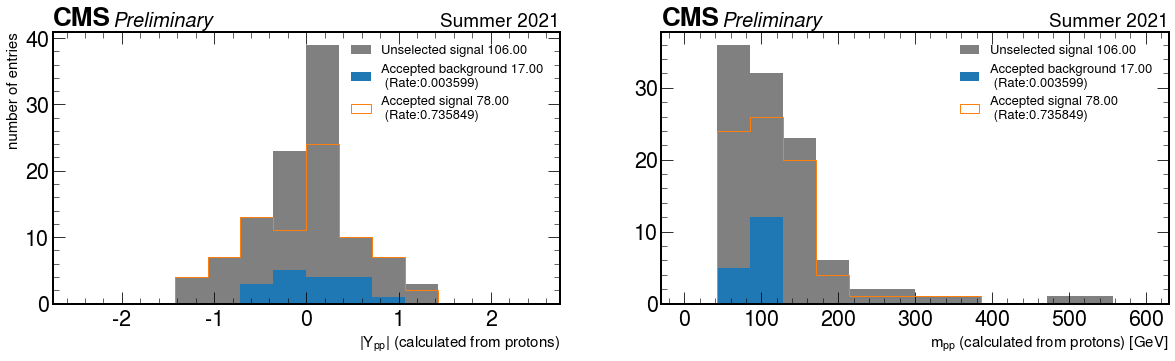

In [269]:
data_mb = abs(bg['mpp']-bg['mll']) 
data_yb = abs(bg['ypp']-bg['yll'])

b_m = []
b_y = []
for i in range(0,len(data_mb)):
    if data_yb[i] < abs(2*sigma_y*bg['yll'][i]):
        if data_mb[i] < abs(2*sigma_m*bg['mll'][i]):
            b_m = np.append(b_m,bg['mpp'][i])
            b_y = np.append(b_y, bg['ypp'][i])
acc_bg = len(b_m)/len(data_yb)
print('acceptance rate from combined background cut:')
print(acc_bg)
s_m = []
s_y = []
data_ms = abs(sig['mpp'] - sig['mll'])
data_ys = abs(sig['ypp'] - sig['yll'])
for i in range(0,len(data)):
    if data_ys[i] < abs(2*sigma_y*sig['yll'][i]):
        if data_ms[i] < abs(2*sigma_m*sig['mll'][i]):        
            s_m = np.append(s_m, sig['mpp'][i])
            s_y = np.append(s_y, sig['ypp'][i])
acc_sig =len(s_m)/len(data_ms)
print('acceptance rate from combined signal cut:')
print(acc_sig)

f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-2.5,2.5,15)
print(len(bg['ypp']))
#ax[0].hist(bg_anal['ypp'],histtype='step',label='Background protons')
ax[0].hist(sig['ypp'],bins, color = "grey",label='Unselected signal %2.2f'%(len(sig['ypp'])))
ax[0].hist(b_y,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_y),acc_bg))
ax[0].hist(s_y,bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_y),acc_sig))
ax[0].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)', ylabel='number of entries')

bins = np.linspace(0,600,15)

ax[1].hist(sig['mpp'],bins, color = "grey",label='Unselected signal %2.2f'%(len(sig['mpp'])))
ax[1].hist(b_m,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_m),acc_bg))
ax[1].hist(s_m,bins, histtype='step', label='Accepted signal %2.2f\n (Rate:%6.6f)'%(len(s_m),acc_sig))
ax[1].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]')

for i in range(2):    
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 20)
    ax[i].legend(fontsize=13)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('FinalResults/surviving_protons', bbox_inches='tight')

In [270]:
# And now we can finally re-write and correct the idea of timing correlation...nice

In [271]:
#define genproton_t variable to work with. (this is the tp1 tp2 which will be later will be used). proton time is given by:
#genproton_t=genvtx_t0+(zpps+genproton_vz)/c where zpps=2e5  (200m)
#then we use the formula for Deltat to obtain the di-proton vertex, and then we compare it to vtx4D_z[0]
#for the signal it should agree, and for the background it should disagree. Here we will define a cut and complete step 2.

0.6839630463322044
-0.16907097435106483


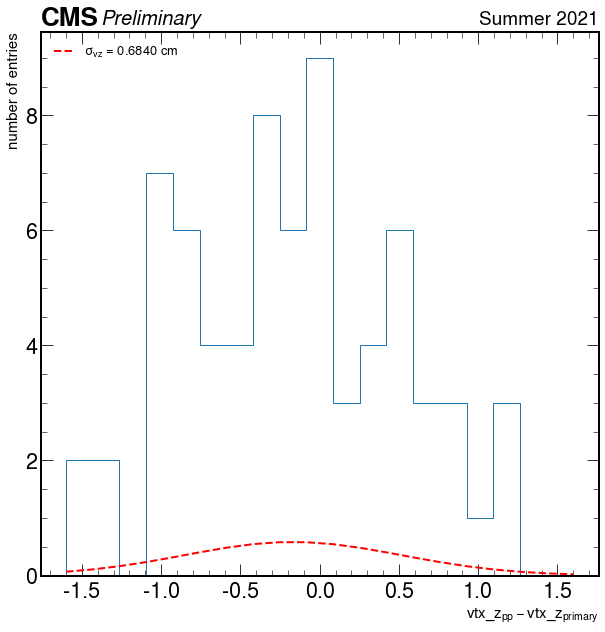

In [272]:
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns

pp_vz = - (sig['pr1_50_t'] - sig['pr2_50_t'])*c/2
vz_4D = sig['pr_vtx_z'].values

data = (pp_vz - vz_4D)
data = data[~np.isnan(data) & (abs(data) < 1.6) ]

bins = np.linspace(-1.6,1.6,20)
f, ax = plt.subplots()
plt.hist(data,bins,histtype='step')
(mu_vz, sigma_vz) = stats.norm.fit(data)
print(sigma_vz)
print(mu_vz)
x=bins
y=stats.norm.pdf(x, mu_vz, sigma_vz)
#print(y)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{vz}$ = %4.4f cm '%(sigma_vz))

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax,fontsize=20)
ax.set(xlabel=r'$vtx\_z_{pp} - vtx\_z_{primary}}$', ylabel='number of entries')
ax.legend(loc='upper left',fontsize=13)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

plt.savefig('FinalResults/fit_vz_ratio_50.png',bbox_inches='tight')

acceptance rate from background cut:
0.16045723962743438
acceptance rate from signal cut:
0.6415094339622641


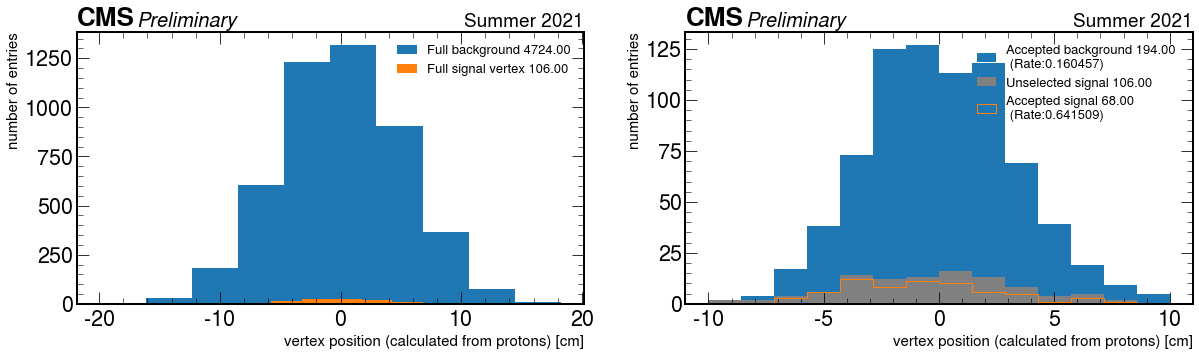

In [273]:
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns
b_p1_t = bg['pr1_50_t']
b_p2_t = bg['pr2_50_t'] 

b_pp_vz = - (b_p1_t - b_p2_t)*c/2 

b_mu = (bg['mu1_vz'] + bg['mu2_vz'])/2
b_vz_4D = bg['pr_vtx_z'].values

data_bz = abs(b_pp_vz - b_vz_4D)

b_z = []
for i in range(0,len(data_bz)):
    if data_bz[i] < abs(2*sigma_vz):
            b_z = np.append(b_z,b_pp_vz[i])
acc_bg = len(b_z)/len(data_bz)
print('acceptance rate from background cut:')
print(acc_bg)

p1_t = sig['pr1_50_t']
p2_t = sig['pr2_50_t'] 

s_pp_vz = - (p1_t - p2_t)*c/2 
s_vz_4D = sig['pr_vtx_z']

data_sz = abs(s_pp_vz - s_vz_4D)
s_z = []
for i in range(0,len(data_sz)):
    if data_sz[i] < abs(2*sigma_vz):
            s_z = np.append(s_z, s_pp_vz[i])
acc_sig =len(s_z)/len(data_sz)
print('acceptance rate from signal cut:')
print(acc_sig)
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)

ax[0].hist(b_pp_vz, label = 'Full background %2.2f'%len(b_pp_vz))
ax[0].hist(s_pp_vz, label='Full signal vertex %2.2f'%len(s_pp_vz))
ax[0].set(xlabel=r'vertex position (calculated from protons) [cm]', ylabel='number of entries')
#ax[0].set_xlim(-20,20)
bins = np.linspace(-10,10,15)


ax[1].hist(b_z, bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b),acc_bg))
ax[1].hist(s_pp_vz,bins, color = "grey",label='Unselected signal %2.2f' %len(s_pp_vz))
ax[1].hist(s_z,bins, histtype = 'step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_z),acc_sig))
ax[1].set(xlabel=r'vertex position (calculated from protons) [cm]', ylabel='number of entries')

for i in range(2):    
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 20)
    ax[i].legend(fontsize=13)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('FinalResults/surviving_protons_vz_50', bbox_inches='tight')

acceptance rate from combined background cut:
0.000846740050804403
acceptance rate from combined signal cut:
0.3113207547169811


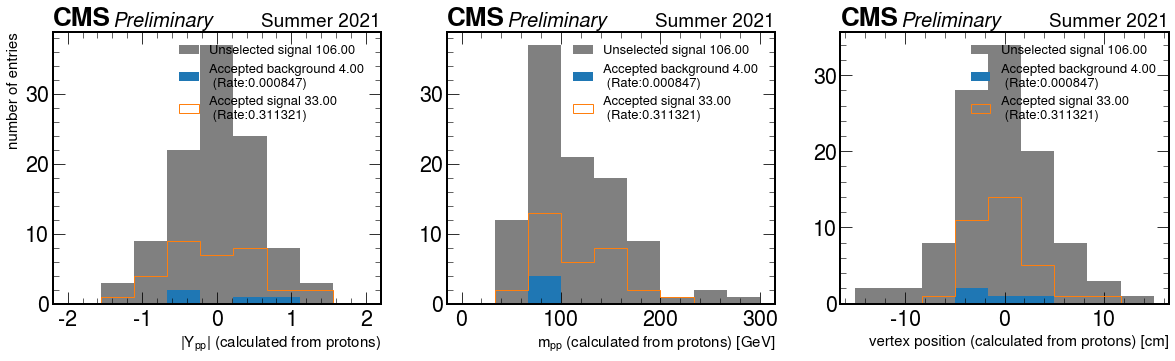

In [274]:
#Both kinematic and the spacial timing:
data_mb = abs(bg['mpp']-bg['mll']) 
data_yb = abs(bg['ypp']-bg['yll'])
b_vz = []
b_m = []
b_y = []
for i in range(0,len(data_mb)):
    if data_yb[i] < abs(2*sigma_y*bg['yll'][i]):
        if data_mb[i] < abs(2*sigma_m*bg['mll'][i]):
            if data_bz[i] < abs(2*sigma_vz):
                b_m = np.append(b_m,bg['mpp'][i])
                b_y = np.append(b_y, bg['ypp'][i])
                b_vz = np.append(b_vz, b_pp_vz[i])
acc_bg = len(b_m)/len(data_yb)
print('acceptance rate from combined background cut:')
print(acc_bg)
s_vz = []
s_m = []
s_y = []
data_ms = abs(sig['mpp'] - sig['mll'])
data_ys = abs(sig['ypp'] - sig['yll'])
for i in range(0,len(data)):
    if data_ys[i] < abs(2*sigma_y*sig['yll'][i]):
        if data_ms[i] < abs(2*sigma_m*sig['mll'][i]): 
            if data_sz[i] < abs(2*sigma_vz):
                s_m = np.append(s_m, sig['mpp'][i])
                s_y = np.append(s_y, sig['ypp'][i])
                s_vz = np.append(s_vz,s_pp_vz[i])
acc_sig =len(s_m)/len(data_ms)
print('acceptance rate from combined signal cut:')
print(acc_sig)
f, ax = plt.subplots(1,3,figsize=(20,5),sharey=False)
bins = np.linspace(-2,2,10)

#ax[0].hist(bg_anal['ypp'],histtype='step',label='Background protons')
ax[0].hist(sig['ypp'],bins, color = "grey",label='Unselected signal %2.2f'%(len(sig['ypp'])))
ax[0].hist(b_y,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_y),acc_bg))
ax[0].hist(s_y,bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_y),acc_sig))
ax[0].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)', ylabel='number of entries')

bins = np.linspace(0,300,10)

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[1].hist(sig['mpp'],bins, color = "grey",label='Unselected signal %2.2f' %len(sig['mpp']))
ax[1].hist(b_m,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_m),acc_bg))
ax[1].hist(s_m,bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_m),acc_sig))
ax[1].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]')

bins = np.linspace(-15,15,10)

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[2].hist(s_pp_vz, bins,color = "grey",label='Unselected signal %2.2f' %len(s_pp_vz))
ax[2].hist(b_vz, bins,label='Accepted background %2.2f\n (Rate:%6.6f)'%(len(b_vz),acc_bg))
ax[2].hist(s_vz, bins,histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_vz),acc_sig))
ax[2].set(xlabel=r'vertex position (calculated from protons) [cm]')


for i in range(3):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 20)
    ax[i].legend(fontsize=13)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('FinalResults/surviving_protons_kin_vz_50', bbox_inches='tight')

106


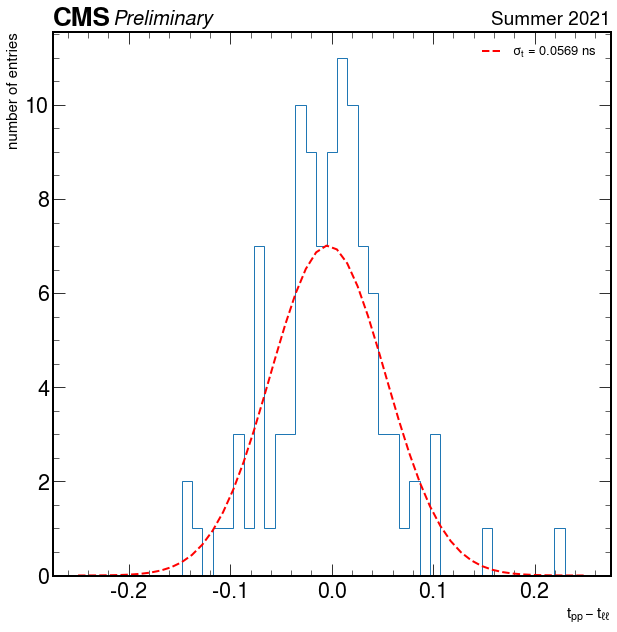

In [275]:
#Vertex position in time: (tp1 + tp2)*c = 2 zpps + t(mu)*c
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns

mask_muon1_measured_time = (sig['mu1_t']>-80) & (sig['mu2_t']>-80)

masked_analysis=sig[mask_muon1_measured_time]
tmu =  ( masked_analysis['mu1_t'].values  + masked_analysis['mu2_t'].values )/2
tpp =  (( masked_analysis['pr1_50_t'].values + masked_analysis['pr2_50_t'].values ) - 2*zpps/c)/2
#to double check if mu1_t/mu2_t is still better !
#tmu = sig['pr_vtx_t'].values
data = (tpp-tmu)

data = data[~np.isnan(data) & ~np.isneginf(data)]
print(len(data))
bins = np.linspace(-0.25,0.25,50)
f, ax = plt.subplots()
plt.hist(data,bins, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area)
(mu_t, sigma_t) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu_t, sigma_t)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{t}$ = %4.4f ns '%(sigma_t))
#print(y)
#print(x)
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax,fontsize = 20)
ax.set(xlabel=r'$t_{pp} - t_{\ell\ell}$', ylabel='number of entries')
ax.legend(fontsize=13)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.savefig('FinalResults/fit_vertex_t_50_prim.png',bbox_inches='tight')

acceptance rate from background cut:
0.34462320067739205
acceptance rate from signal cut:
0.9528301886792453


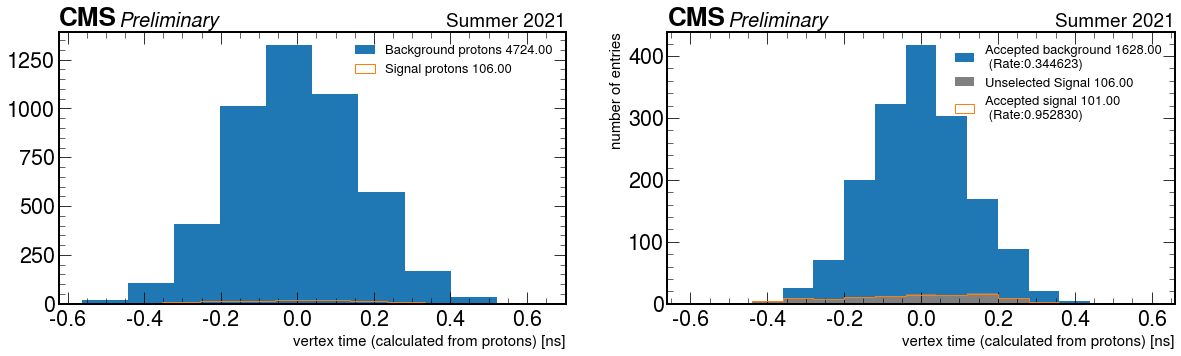

In [276]:
#timing
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns
mask_measured_time = (bg['mu1_t'] >-80) & (bg['mu2_t']>-80)
b_masked_analysis=bg[mask_measured_time]

mu1_t = b_masked_analysis['mu1_t'].values 
mu2_t = b_masked_analysis['mu2_t'].values 

b_tmu = (mu1_t+mu2_t)/2 
b_p1_t = b_masked_analysis['pr1_50_t'].values
b_p2_t = b_masked_analysis['pr2_50_t'].values
b_tpp = (( b_p1_t + b_p2_t) - 2*zpps/c)/2

#print(b_tpp)

b_t = []
data_bt = abs(b_tpp - b_tmu)

for i in range(0,len(data_bt)):
    if data_bt[i] < abs(2*sigma_t):
            b_t = np.append(b_t,b_tpp[i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from background cut:')
print(acc_bg)

mask_muon1_measured_time = (sig['mu1_t']>-80) & (sig['mu2_t']>-80)

masked_analysis=sig[mask_muon1_measured_time]
tmu1 = masked_analysis['mu1_t'].values 
tmu2 = masked_analysis['mu2_t'].values 

#print(len(tmu1))
p1_t =  masked_analysis['pr1_50_t'].values
p2_t =  masked_analysis['pr2_50_t'].values

s_tpp =(( p1_t + p2_t) - 2*zpps/c)/2
s_tmu = ( tmu1 + tmu2)/2

data_st = abs(s_tpp - s_tmu)
s_t = []
for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t):
            s_t = np.append(s_t, s_tpp[i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from signal cut:')
print(acc_sig)

f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-8,8,16)
ax[0].hist(b_tpp, label = 'Background protons %2.2f' %len(b_tpp))
ax[0].hist(s_tpp,histtype='step', label='Signal protons %2.2f' %len(s_tpp))
ax[0].set(xlabel=r'vertex time (calculated from protons) [ns]')
#ax[0].set_xlim(-20,20)
bins=np.linspace(-0.6,0.6,16)
ax[1].hist(b_t, bins,label='Accepted background %2.2f\n (Rate:%6.6f)'%(len(b_t),acc_bg))
ax[1].hist(s_tpp,bins, color= 'grey', label = 'Unselected Signal %2.2f' %len(s_tpp))
ax[1].hist(s_t,bins, histtype='step',label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_t),acc_sig))
ax[1].set(xlabel=r'vertex time (calculated from protons) [ns]', ylabel='number of entries')

for i in range(2):    
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 20)
    ax[i].legend(fontsize=13)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('FinalResults/surviving_protons_t_50', bbox_inches='tight')

acceptance rate from background cut:
0.056731583403895
acceptance rate from signal cut:
0.6132075471698113


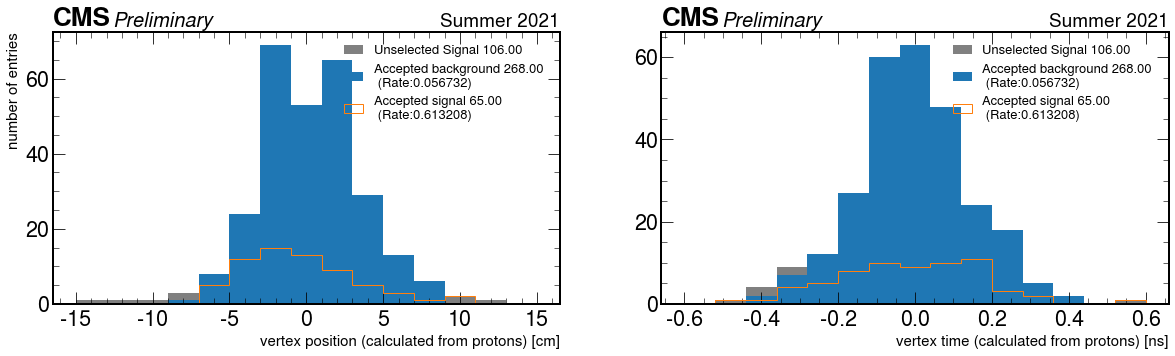

In [277]:
#combined timing and spatial vertex cuts:
b_z = []
b_t = []
for i in range(0,len(data_bt)):
    if data_bt[i] < abs(2*sigma_t):
        if data_bz[i] < abs(2*sigma_vz):
                b_z = np.append(b_z,b_pp_vz[i])
                b_t = np.append(b_t,b_tpp[i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from background cut:')
print(acc_bg)

s_z = []
s_t = []
for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t):
        if data_sz[i] < abs(2*sigma_vz):
                s_z = np.append(s_z, s_pp_vz[i])
                s_t = np.append(s_t, s_tpp[i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from signal cut:')
print(acc_sig)
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-15,15,16)
ax[0].hist(s_pp_vz, bins,color= 'grey', label = 'Unselected Signal %2.2f' %len(s_pp_vz))
ax[0].hist(b_z, bins,label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_z),acc_bg))
ax[0].hist(s_z,bins, histtype='step',label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_z),acc_sig))
ax[0].set(xlabel=r'vertex position (calculated from protons) [cm]', ylabel='number of entries')


bins=np.linspace(-0.6,0.6,16)

ax[1].hist(s_tpp,bins, color= 'grey', label = 'Unselected Signal %2.2f'%len(s_tpp))
ax[1].hist(b_t,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_t),acc_bg))
ax[1].hist(s_t,bins,histtype='step',label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_t),acc_sig))
ax[1].set(xlabel=r'vertex time (calculated from protons) [ns]')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 20)
    ax[i].legend(fontsize=13)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('FinalResults/surviving_protons_tvz_50', bbox_inches='tight')

acceptance rate from combined background cut:
0.002540220152413209
acceptance rate from combined signal cut:
0.7075471698113207
4724


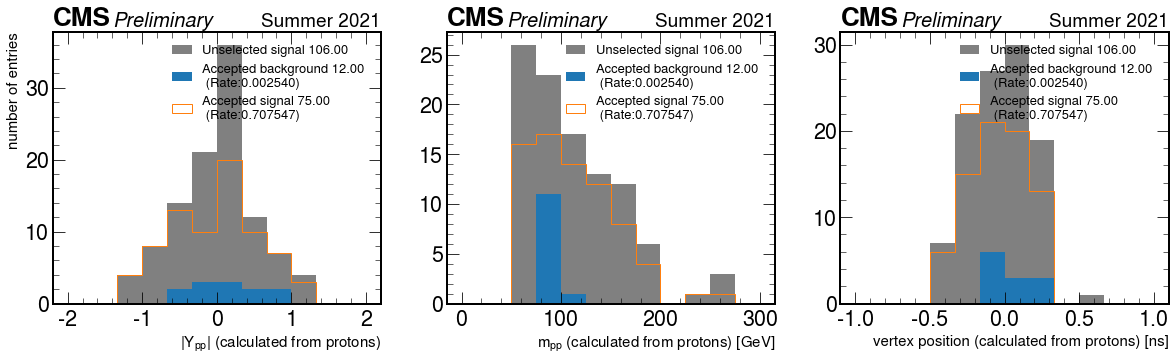

In [278]:
#Both kinematic and the timing:
data_mb = abs(bg['mpp']-bg['mll']) 
data_yb = abs(bg['ypp']-bg['yll'])

b_m = []
b_y = []
b_t = []
for i in range(0,len(data_bt)):
    if data_bt[i] < abs(2*sigma_t):
        if data_yb[i] < abs(2*sigma_y*bg['yll'][i]):
            if data_mb[i] < abs(2*sigma_m*bg['mll'][i]):
                b_t = np.append(b_t,b_tpp[i])
                b_m = np.append(b_m,bg['mpp'][i])
                b_y = np.append(b_y, bg['ypp'][i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from combined background cut:')
print(acc_bg)
s_t = []
s_m = []
s_y = []
              
data_ms = abs(sig['mpp'] - sig['mll'])
data_ys = abs(sig['ypp'] - sig['yll'])

for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t):
        if data_ys[i] < abs(2*sigma_y*sig['yll'][i]):
            if data_ms[i] < abs(2*sigma_m*sig['mll'][i]):
                    s_t = np.append(s_t, s_tpp[i])
                    s_m = np.append(s_m, sig['mpp'][i])
                    s_y = np.append(s_y, sig['ypp'][i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from combined signal cut:')
print(acc_sig)
f, ax = plt.subplots(1,3,figsize=(20,5),sharey=False)
bins = np.linspace(-2,2,13)
print(len(bg['ypp']))
#ax[0].hist(bg_anal['ypp'],histtype='step',label='Background protons')
ax[0].hist(sig['ypp'],bins, color = "grey",label='Unselected signal %2.2f'%len(sig['ypp']))
ax[0].hist(b_y,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_y),acc_bg))
ax[0].hist(s_y,bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_y),acc_sig))
ax[0].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)', ylabel='number of entries')
ax[0].legend(fontsize=13, loc = 'upper left')
bins = np.linspace(0,300,13)
#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[1].hist(sig['mpp'],bins, color = "grey",label='Unselected signal %2.2f'%len(sig['mpp']))
ax[1].hist(b_m,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_m),acc_bg))
ax[1].hist(s_m,bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_m),acc_sig))
ax[1].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]')
ax[1].legend(fontsize=13, loc = 'upper right')

bins=np.linspace(-1,1,13)
ax[2].hist(s_tpp,bins, color = "grey",label='Unselected signal %2.2f' %len(s_tpp))
ax[2].hist(b_t, bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_t),acc_bg))
ax[2].hist(s_t, bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_t),acc_sig))
ax[2].set(xlabel=r'vertex position (calculated from protons) [ns]')
ax[2].legend(fontsize=13, loc = 'upper left')

for i in range(3):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 20)
    ax[i].legend(fontsize=13, loc = 'best')
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('FinalResults/surviving_protons_kin_t_50', bbox_inches='tight')

acceptance rate from combined background cut:
0.0006350550381033022
acceptance rate from combined signal cut:
0.4339622641509434
4724


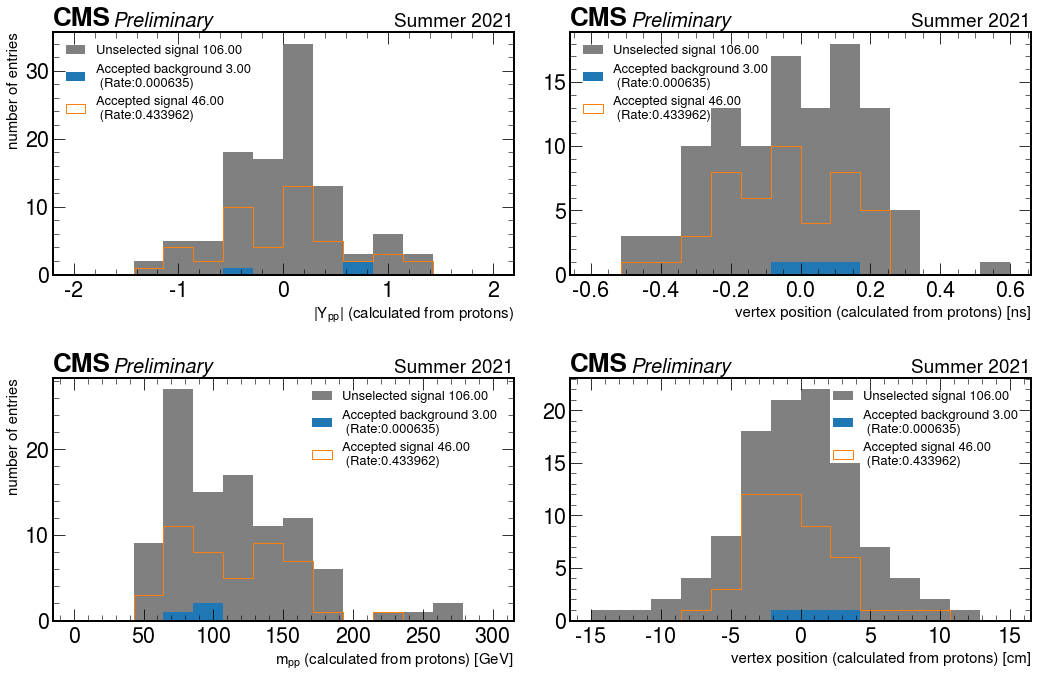

In [282]:
#All kinematic and timing
#Both kinematic and the timing:
data_mb = abs(bg['mpp']-bg['mll']) 
data_yb = abs(bg['ypp']-bg['yll'])

b_m = []
b_y = []
b_t = []
b_vz= []
for i in range(0,len(data_bt)):
    if data_bt[i] < abs(2*sigma_t):
        if data_bz[i] < abs(2*sigma_vz):           
            if data_yb[i] < abs(2*sigma_y*bg['yll'][i]):
                if data_mb[i] < abs(2*sigma_m*bg['mll'][i]):
                    b_t = np.append(b_t,b_tpp[i])
                    b_vz = np.append(b_vz,b_pp_vz[i])
                    b_m = np.append(b_m,bg['mpp'][i])
                    b_y = np.append(b_y, bg['ypp'][i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from combined background cut:')
print(acc_bg)
s_t = []
s_m = []
s_y = []
s_vz= []             
data_ms = abs(sig['mpp'] - sig['mll'])
data_ys = abs(sig['ypp'] - sig['yll'])

for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t):  
        if data_sz[i] < abs(2*sigma_vz):
            if data_ys[i] < abs(2*sigma_y*sig['yll'][i]):
                if data_ms[i] < abs(2*sigma_m*sig['mll'][i]):
                        s_t = np.append(s_t, s_tpp[i])
                        s_vz = np.append(s_vz, s_pp_vz[i])
                        s_m = np.append(s_m, sig['mpp'][i])
                        s_y = np.append(s_y, sig['ypp'][i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from combined signal cut:')
print(acc_sig)
f, ax = plt.subplots(2,2,figsize=(15,10),sharey=False)
bins = np.linspace(-2,2,15)
print(len(bg['ypp']))
#ax[0].hist(bg_anal['ypp'],histtype='step',label='Background protons')
ax[0][0].hist(sig['ypp'],bins, color = "grey",label='Unselected signal %2.2f'%len(sig['ypp']))
ax[0][0].hist(b_y,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_y),acc_bg))
ax[0][0].hist(s_y,bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_y),acc_sig))
ax[0][0].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)', ylabel='number of entries')

bins = np.linspace(0,300,15)

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[1][0].hist(sig['mpp'],bins, color = "grey",label='Unselected signal %2.2f'%len(sig['mpp']))
ax[1][0].hist(b_m,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_m),acc_bg))
ax[1][0].hist(s_m,bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_m),acc_sig))
ax[1][0].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]',ylabel='number of entries')

bins = np.linspace(-0.6,0.6,15)
#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[0][1].hist(s_tpp,bins, color = "grey",label='Unselected signal %2.2f'%len(s_tpp))
ax[0][1].hist(b_t,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_t),acc_bg))
ax[0][1].hist(s_t, bins, histtype='step', label='Accepted signal %2.2f\n (Rate:%6.6f)'%(len(s_t),acc_sig))
ax[0][1].set(xlabel=r'vertex position (calculated from protons) [ns]')

bins = np.linspace(-15,15,15)
#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[1][1].hist(s_pp_vz,bins, color = "grey",label='Unselected signal %2.2f'%len(s_pp_vz))
ax[1][1].hist(b_vz,bins, label='Accepted background %2.2f\n (Rate:%6.6f)'%(len(b_vz),acc_bg))
ax[1][1].hist(s_vz,bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_vz),acc_sig))
ax[1][1].set(xlabel=r'vertex position (calculated from protons) [cm]')


for i in range(2):
    for j in range(2):
        hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i][j], fontsize = 20)
        ax[i][j].legend(fontsize=13)
        ax[i][j].xaxis.label.set_size(15)
        ax[i][j].yaxis.label.set_size(15)
f.tight_layout()#pad=3.0)
plt.savefig('FinalResults/surviving_protons_kin_tvz_50', bbox_inches='tight')

### Resolution HL-LHC 20ps

0.4396685473318769
0.06077744025682275


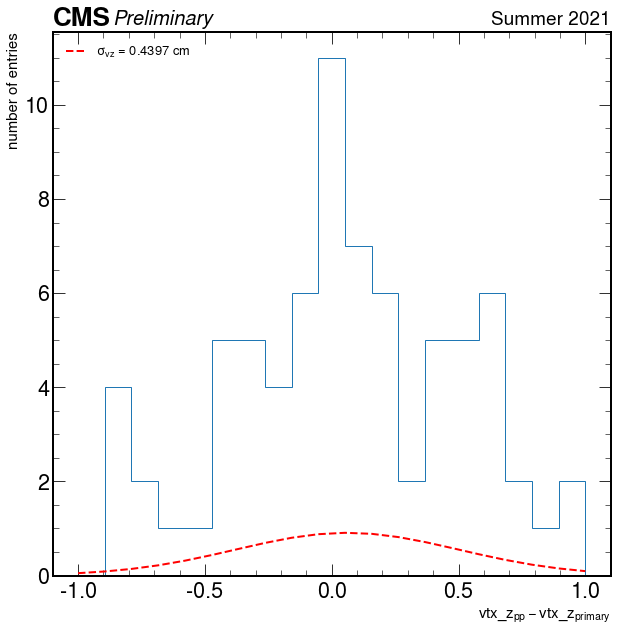

In [249]:
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns

pp_vz = - (sig['pr1_20_t'] - sig['pr2_20_t'])*c/2 
vz_4D = sig['pr_vtx_z'].values

data = (pp_vz - vz_4D)
data = data[~np.isnan(data) & (abs(data) < 1) ]

bins=np.linspace(-1,1,20)
f, ax = plt.subplots()
plt.hist(data,bins,histtype='step')
#print(data)  norm.pdf(x, loc, scale)
#fit to gaussian (to avoid bias from outliers restrict the fitted area):  = analysis['s_mpp']-analysis['s_mll'] <
(mu_vz, sigma_vz) = stats.norm.fit(data)
print(sigma_vz)
print(mu_vz)
#bins = np.linspace(-5,5,103)
x=bins
y=stats.norm.pdf(x, mu_vz, sigma_vz)
#print(y)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{vz}$ = %4.4f cm '%(sigma_vz))

hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax,fontsize=20)
ax.set(xlabel=r'$vtx\_z_{pp} - vtx\_z_{primary}}$', ylabel='number of entries')
ax.legend(loc='upper left',fontsize=13)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

plt.savefig('FinalResults/fit_vz_ratio_20.png',bbox_inches='tight')

acceptance rate from background cut:
0.09949195596951736
acceptance rate from signal cut:
0.6886792452830188


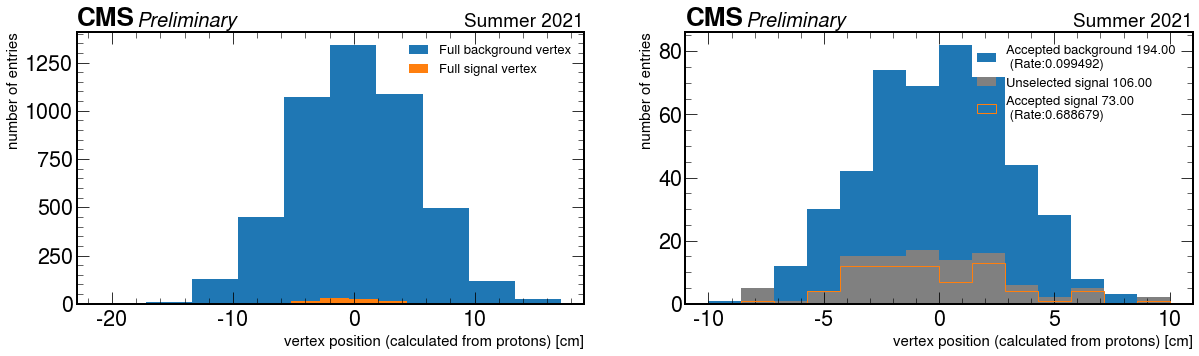

In [250]:
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns
b_p1_t = bg['pr1_20_t']
b_p2_t = bg['pr2_20_t'] 

b_pp_vz = - (b_p1_t - b_p2_t)*c/2 

b_mu = (bg['mu1_vz'] + bg['mu2_vz'])/2
b_vz_4D = bg['pr_vtx_z'].values

data_bz = abs(b_pp_vz - b_vz_4D)

b_z = []
for i in range(0,len(data_bz)):
    if data_bz[i] < abs(2*sigma_vz):
            b_z = np.append(b_z,b_pp_vz[i])
acc_bg = len(b_z)/len(data_bz)
print('acceptance rate from background cut:')
print(acc_bg)

p1_t = sig['pr1_20_t']
p2_t = sig['pr2_20_t'] 

s_pp_vz = - (p1_t - p2_t)*c/2 

s_vz_4D = sig['pr_vtx_z']

data_sz = abs(s_pp_vz - s_vz_4D)
s_z = []
for i in range(0,len(data_sz)):
    if data_sz[i] < abs(2*sigma_vz):
            s_z = np.append(s_z, s_pp_vz[i])
acc_sig =len(s_z)/len(data_sz)
print('acceptance rate from signal cut:')
print(acc_sig)


f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)

ax[0].hist(b_pp_vz, label = 'Full background vertex')
ax[0].hist(s_pp_vz, label='Full signal vertex')
ax[0].set(xlabel=r'vertex position (calculated from protons) [cm]', ylabel='number of entries')
bins = np.linspace(-10,10,15)

ax[1].hist(b_z, bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b),acc_bg))
ax[1].hist(s_pp_vz,bins, color = "grey",label='Unselected signal %2.2f' %len(s_pp_vz))
ax[1].hist(s_z,bins, histtype = 'step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_z),acc_sig))
ax[1].set(xlabel=r'vertex position (calculated from protons) [cm]', ylabel='number of entries')

for i in range(2):    
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 20)
    ax[i].legend(fontsize=13)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('FinalResults/surviving_protons_vz_20', bbox_inches='tight')

acceptance rate from combined background cut:
0.0004233700254022015
acceptance rate from combined signal cut:
0.3584905660377358
4724


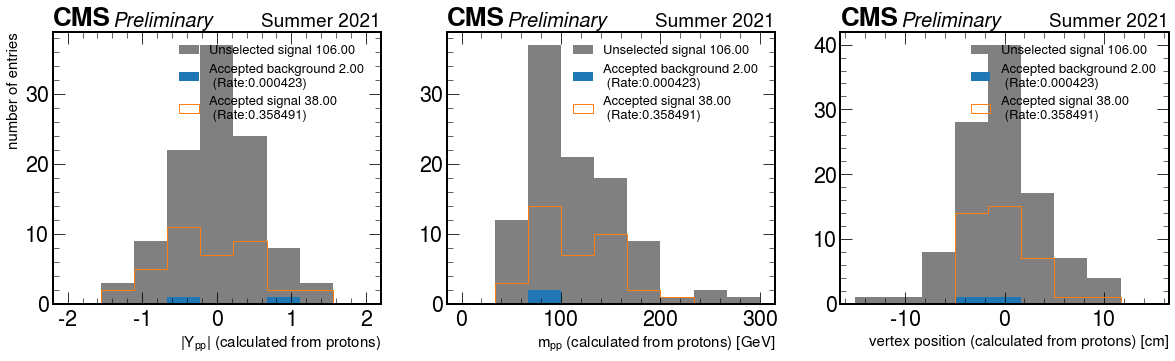

In [252]:
#Both kinematic and the spacial timing:
data_mb = abs(bg['mpp']-bg['mll']) 
data_yb = abs(bg['ypp']-bg['yll'])
b_vz = []
b_m = []
b_y = []
for i in range(0,len(data_mb)):
    if data_yb[i] < abs(2*sigma_y*bg['yll'][i]):
        if data_mb[i] < abs(2*sigma_m*bg['mll'][i]):
            if data_bz[i] < abs(2*sigma_vz):
                b_m = np.append(b_m,bg['mpp'][i])
                b_y = np.append(b_y, bg['ypp'][i])
                b_vz = np.append(b_vz, b_pp_vz[i])
acc_bg = len(b_m)/len(data_yb)
print('acceptance rate from combined background cut:')
print(acc_bg)
s_vz = []
s_m = []
s_y = []
data_ms = abs(sig['mpp'] - sig['mll'])
data_ys = abs(sig['ypp'] - sig['yll'])
for i in range(0,len(data)):
    if data_ys[i] < abs(2*sigma_y*sig['yll'][i]):
        if data_ms[i] < abs(2*sigma_m*sig['mll'][i]): 
            if data_sz[i] < abs(2*sigma_vz):
                s_m = np.append(s_m, sig['mpp'][i])
                s_y = np.append(s_y, sig['ypp'][i])
                s_vz = np.append(s_vz,s_pp_vz[i])
acc_sig =len(s_m)/len(data_ms)
print('acceptance rate from combined signal cut:')
print(acc_sig)

f, ax = plt.subplots(1,3,figsize=(20,5),sharey=False)
bins = np.linspace(-2,2,10)
print(len(bg['ypp']))
#ax[0].hist(bg_anal['ypp'],histtype='step',label='Background protons')
ax[0].hist(sig['ypp'],bins, color = "grey",label='Unselected signal %2.2f'%(len(sig['ypp'])))
ax[0].hist(b_y,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_y),acc_bg))
ax[0].hist(s_y,bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_y),acc_sig))
ax[0].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)', ylabel='number of entries')

bins = np.linspace(0,300,10)

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[1].hist(sig['mpp'],bins, color = "grey",label='Unselected signal %2.2f' %len(sig['mpp']))
ax[1].hist(b_m,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_m),acc_bg))
ax[1].hist(s_m,bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_m),acc_sig))
ax[1].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]')

bins = np.linspace(-15,15,10)

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[2].hist(s_pp_vz, bins,color = "grey",label='Unselected signal %2.2f' %len(s_pp_vz))
ax[2].hist(b_vz, bins,label='Accepted background %2.2f\n (Rate:%6.6f)'%(len(b_vz),acc_bg))
ax[2].hist(s_vz, bins,histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_vz),acc_sig))
ax[2].set(xlabel=r'vertex position (calculated from protons) [cm]')


for i in range(3):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 20)
    ax[i].legend(fontsize=13, loc = 'best')
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('FinalResults/surviving_protons_kin_vz_20', bbox_inches='tight')

106


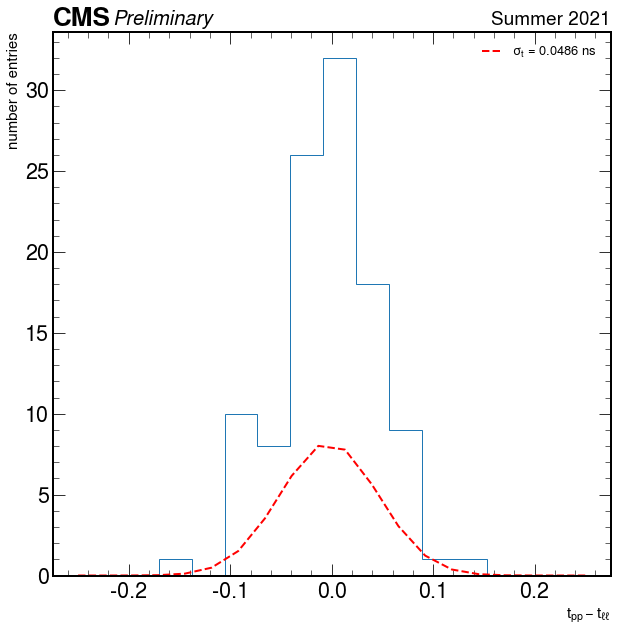

In [253]:
#Vertex position in time: (tp1 + tp2)*c = 2 zpps + t(mu)*c
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns

mask_muon1_measured_time = (sig['mu1_t']>-80) & (sig['mu2_t']>-80)

masked_analysis=sig[mask_muon1_measured_time]
tmu =  ( masked_analysis['mu1_t'].values  + masked_analysis['mu2_t'].values )/2
tpp =  (( masked_analysis['pr1_20_t'].values + masked_analysis['pr2_20_t'].values ) - 2*zpps/c)/2

data = (tpp-tmu)
data = data[~np.isnan(data) & ~np.isneginf(data)]
print(len(data))
bins = np.linspace(-0.25,0.25,20)

f, ax = plt.subplots()
plt.hist(data, histtype='step')

#fit to gaussian (to avoid bias from outliers restrict the fitted area)
(mu_t, sigma_t) = stats.norm.fit(data)
x=bins
y=stats.norm.pdf(x, mu_t, sigma_t)
ax.plot(x, y, 'r--', linewidth=2,label='$\sigma_{t}$ = %4.4f ns '%(sigma_t))
#print(y)
#print(x)
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax,fontsize = 20)
ax.set(xlabel=r'$t_{pp} - t_{\ell\ell}$', ylabel='number of entries')
ax.legend(fontsize=13)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.savefig('FinalResults/fit_vertex_t_20.png',bbox_inches='tight')

acceptance rate from background cut:
0.29360711261642675
acceptance rate from signal cut:
0.9528301886792453


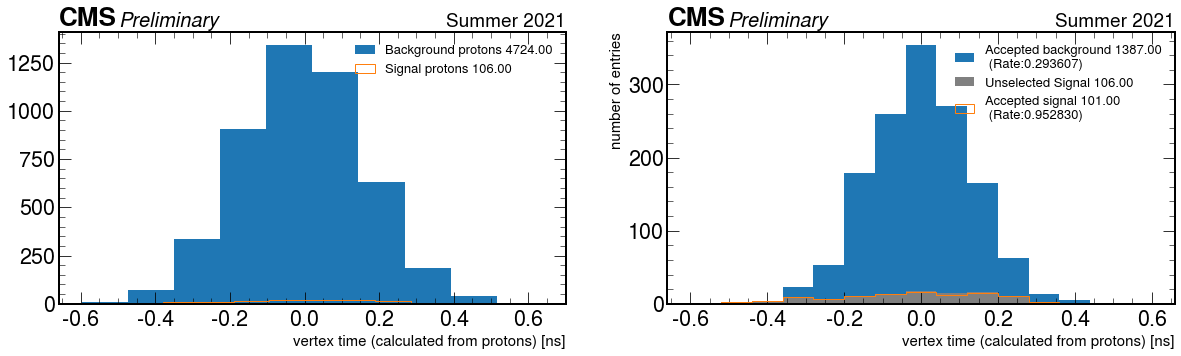

In [254]:
#timing
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns
mask_measured_time = (bg['mu1_t'] >-80) & (bg['mu2_t']>-80)
b_masked_analysis=bg[mask_measured_time]

mu1_t = b_masked_analysis['mu1_t'].values 
mu2_t = b_masked_analysis['mu2_t'].values 

b_tmu = (mu1_t+mu2_t)/2 

b_p1_t = b_masked_analysis['pr1_20_t'].values
b_p2_t = b_masked_analysis['pr2_20_t'].values
b_tpp = (( b_p1_t + b_p2_t) - 2*zpps/c)/2

#print(b_tpp)

b_t = []
data_bt = abs(b_tpp - b_tmu)

for i in range(0,len(data_bt)):
    if data_bt[i] < abs(2*sigma_t):
            b_t = np.append(b_t,b_tpp[i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from background cut:')
print(acc_bg)

mask_muon1_measured_time = (sig['mu1_t']>-80) & (sig['mu2_t']>-80)

masked_analysis=sig[mask_muon1_measured_time]
tmu1 = masked_analysis['mu1_t'].values 
tmu2 = masked_analysis['mu2_t'].values 

#print(len(tmu1))
p1_t =  masked_analysis['pr1_20_t'].values
p2_t =  masked_analysis['pr2_20_t'].values

s_tpp =(( p1_t + p2_t) - 2*zpps/c)/2
s_tmu = ( tmu1 + tmu2)/2

data_st = abs(s_tpp - s_tmu)
s_t = []
for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t):
            s_t = np.append(s_t, s_tpp[i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from signal cut:')
print(acc_sig)

f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-8,8,16)
ax[0].hist(b_tpp, label = 'Background protons %2.2f' %len(b_tpp))
ax[0].hist(s_tpp,histtype='step', label='Signal protons %2.2f' %len(s_tpp))
ax[0].set(xlabel=r'vertex time (calculated from protons) [ns]')
#ax[0].set_xlim(-20,20)
bins=np.linspace(-0.6,0.6,16)
ax[1].hist(b_t, bins,label='Accepted background %2.2f\n (Rate:%6.6f)'%(len(b_t),acc_bg))
ax[1].hist(s_tpp,bins, color= 'grey', label = 'Unselected Signal %2.2f' %len(s_tpp))
ax[1].hist(s_t,bins, histtype='step',label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_t),acc_sig))
ax[1].set(xlabel=r'vertex time (calculated from protons) [ns]', ylabel='number of entries')

for i in range(2):    
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 20)
    ax[i].legend(fontsize=13)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('FinalResults/surviving_protons_t_20', bbox_inches='tight')

acceptance rate from background cut:
0.029212531752751906
acceptance rate from signal cut:
0.660377358490566


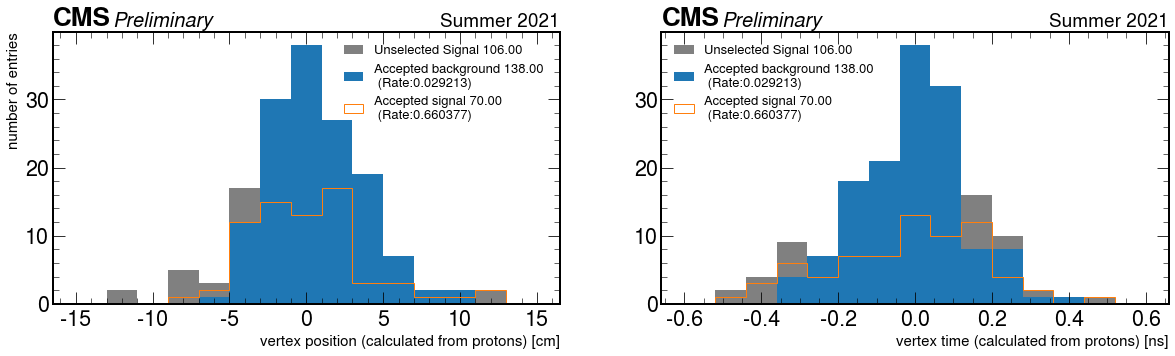

In [255]:
#combined timing and spatial vertex cuts:
b_z = []
b_t = []
for i in range(0,len(data_bt)):
    if data_bt[i] < abs(2*sigma_t):
        if data_bz[i] < abs(2*sigma_vz):
                b_z = np.append(b_z,b_pp_vz[i])
                b_t = np.append(b_t,b_tpp[i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from background cut:')
print(acc_bg)

s_z = []
s_t = []
for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t):
        if data_sz[i] < abs(2*sigma_vz):
                s_z = np.append(s_z, s_pp_vz[i])
                s_t = np.append(s_t, s_tpp[i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from signal cut:')
print(acc_sig)

f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
bins = np.linspace(-15,15,16)
ax[0].hist(s_pp_vz, bins,color= 'grey', label = 'Unselected Signal %2.2f' %len(s_pp_vz))
ax[0].hist(b_z, bins,label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_z),acc_bg))
ax[0].hist(s_z,bins, histtype='step',label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_z),acc_sig))
ax[0].set(xlabel=r'vertex position (calculated from protons) [cm]', ylabel='number of entries')


bins=np.linspace(-0.6,0.6,16)

ax[1].hist(s_tpp,bins, color= 'grey', label = 'Unselected Signal %2.2f'%len(s_tpp))
ax[1].hist(b_t,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_t),acc_bg))
ax[1].hist(s_t,bins,histtype='step',label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_t),acc_sig))
ax[1].set(xlabel=r'vertex time (calculated from protons) [ns]')

for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 20)
    ax[i].legend(fontsize=13)
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('FinalResults/surviving_protons_tvz_20', bbox_inches='tight')

acceptance rate from combined background cut:
0.001905165114309907
acceptance rate from combined signal cut:
0.6981132075471698
4724


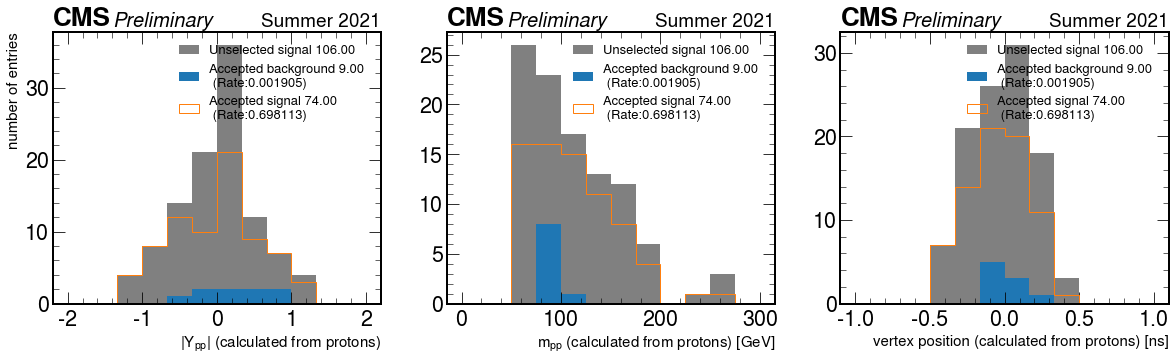

In [258]:
#Both kinematic and the timing:
data_mb = abs(bg['mpp']-bg['mll']) 
data_yb = abs(bg['ypp']-bg['yll'])

b_m = []
b_y = []
b_t = []
for i in range(0,len(data_bt)):
    if data_bt[i] < abs(2*sigma_t):
        if data_yb[i] < abs(2*sigma_y*bg['yll'][i]):
            if data_mb[i] < abs(2*sigma_m*bg['mll'][i]):
                b_t = np.append(b_t,b_tpp[i])
                b_m = np.append(b_m,bg['mpp'][i])
                b_y = np.append(b_y, bg['ypp'][i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from combined background cut:')
print(acc_bg)
s_t = []
s_m = []
s_y = []
              
data_ms = abs(sig['mpp'] - sig['mll'])
data_ys = abs(sig['ypp'] - sig['yll'])

for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t):
        if data_ys[i] < abs(2*sigma_y*sig['yll'][i]):
            if data_ms[i] < abs(2*sigma_m*sig['mll'][i]):
                    s_t = np.append(s_t, s_tpp[i])
                    s_m = np.append(s_m, sig['mpp'][i])
                    s_y = np.append(s_y, sig['ypp'][i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from combined signal cut:')
print(acc_sig)

f, ax = plt.subplots(1,3,figsize=(20,5),sharey=False)
bins = np.linspace(-2,2,13)
print(len(bg['ypp']))
#ax[0].hist(bg_anal['ypp'],histtype='step',label='Background protons')
ax[0].hist(sig['ypp'],bins, color = "grey",label='Unselected signal %2.2f'%len(sig['ypp']))
ax[0].hist(b_y,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_y),acc_bg))
ax[0].hist(s_y,bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_y),acc_sig))
ax[0].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)', ylabel='number of entries')
ax[0].legend(fontsize=13, loc = 'upper left')
bins = np.linspace(0,300,13)
#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[1].hist(sig['mpp'],bins, color = "grey",label='Unselected signal %2.2f'%len(sig['mpp']))
ax[1].hist(b_m,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_m),acc_bg))
ax[1].hist(s_m,bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_m),acc_sig))
ax[1].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]')
ax[1].legend(fontsize=13, loc = 'upper right')

bins=np.linspace(-1,1,13)
ax[2].hist(s_tpp,bins, color = "grey",label='Unselected signal %2.2f' %len(s_tpp))
ax[2].hist(b_t, bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_t),acc_bg))
ax[2].hist(s_t, bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_t),acc_sig))
ax[2].set(xlabel=r'vertex position (calculated from protons) [ns]')
ax[2].legend(fontsize=13, loc = 'upper left')

for i in range(3):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i], fontsize = 20)
    ax[i].legend(fontsize=13, loc = 'best')
    ax[i].xaxis.label.set_size(15)
    ax[i].yaxis.label.set_size(15)
plt.savefig('FinalResults/surviving_protons_kin_t_20', bbox_inches='tight')

acceptance rate from combined background cut:
0.0004233700254022015
acceptance rate from combined signal cut:
0.46226415094339623
4724


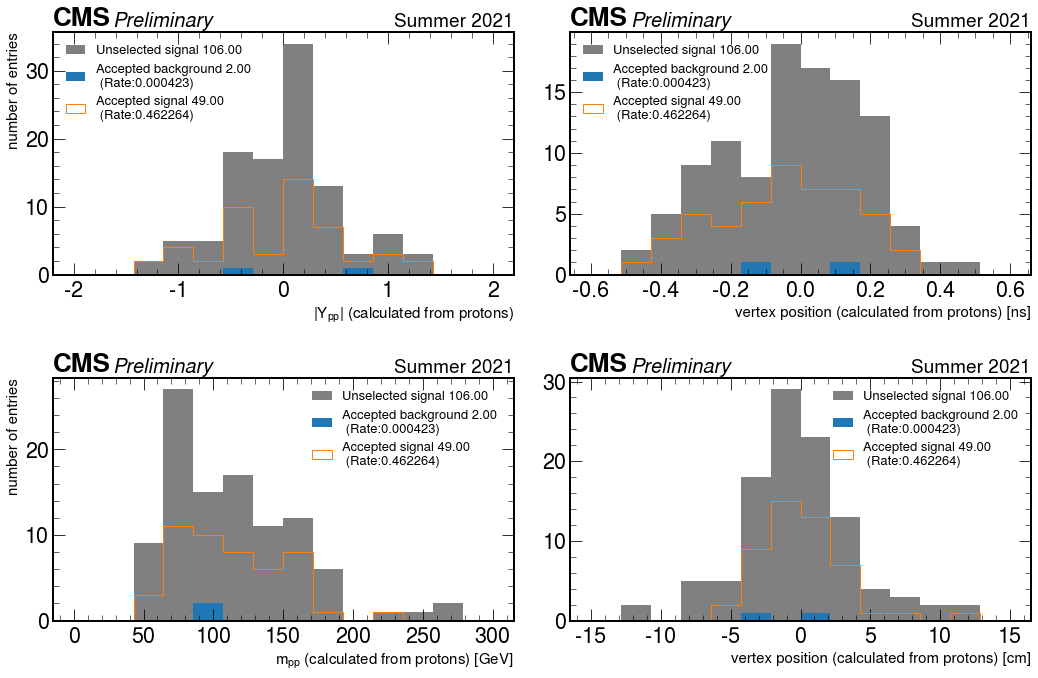

In [260]:
#All kinematic and timing
#Both kinematic and the timing:
data_mb = abs(bg['mpp']-bg['mll']) 
data_yb = abs(bg['ypp']-bg['yll'])

b_m = []
b_y = []
b_t = []
b_vz= []
for i in range(0,len(data_bt)):
    if data_bt[i] < abs(2*sigma_t):
        if data_bz[i] < abs(2*sigma_vz):           
            if data_yb[i] < abs(2*sigma_y*bg['yll'][i]):
                if data_mb[i] < abs(2*sigma_m*bg['mll'][i]):
                    b_t = np.append(b_t,b_tpp[i])
                    b_vz = np.append(b_vz,b_pp_vz[i])
                    b_m = np.append(b_m,bg['mpp'][i])
                    b_y = np.append(b_y, bg['ypp'][i])
acc_bg = len(b_t)/len(data_bt)
print('acceptance rate from combined background cut:')
print(acc_bg)
s_t = []
s_m = []
s_y = []
s_vz= []             
data_ms = abs(sig['mpp'] - sig['mll'])
data_ys = abs(sig['ypp'] - sig['yll'])

for i in range(0,len(data_st)):
    if data_st[i] < abs(2*sigma_t):  
        if data_sz[i] < abs(2*sigma_vz):
            if data_ys[i] < abs(2*sigma_y*sig['yll'][i]):
                if data_ms[i] < abs(2*sigma_m*sig['mll'][i]):
                        s_t = np.append(s_t, s_tpp[i])
                        s_vz = np.append(s_vz, s_pp_vz[i])
                        s_m = np.append(s_m, sig['mpp'][i])
                        s_y = np.append(s_y, sig['ypp'][i])
acc_sig =len(s_t)/len(data_st)
print('acceptance rate from combined signal cut:')
print(acc_sig)

f, ax = plt.subplots(2,2,figsize=(15,10),sharey=False)
bins = np.linspace(-2,2,15)
print(len(bg['ypp']))
#ax[0].hist(bg_anal['ypp'],histtype='step',label='Background protons')
ax[0][0].hist(sig['ypp'],bins, color = "grey",label='Unselected signal %2.2f'%len(sig['ypp']))
ax[0][0].hist(b_y,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_y),acc_bg))
ax[0][0].hist(s_y,bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_y),acc_sig))
ax[0][0].set(xlabel=r'$|Y_{pp}|$ (calculated from protons)', ylabel='number of entries')

bins = np.linspace(0,300,15)

#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[1][0].hist(sig['mpp'],bins, color = "grey",label='Unselected signal %2.2f'%len(sig['mpp']))
ax[1][0].hist(b_m,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_m),acc_bg))
ax[1][0].hist(s_m,bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_m),acc_sig))
ax[1][0].set(xlabel=r'$m_{pp}$ (calculated from protons) [GeV]',ylabel='number of entries')

bins = np.linspace(-0.6,0.6,15)
#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[0][1].hist(s_tpp,bins, color = "grey",label='Unselected signal %2.2f'%len(s_tpp))
ax[0][1].hist(b_t,bins, label='Accepted background %2.2f \n (Rate:%6.6f)'%(len(b_t),acc_bg))
ax[0][1].hist(s_t, bins, histtype='step', label='Accepted signal %2.2f\n (Rate:%6.6f)'%(len(s_t),acc_sig))
ax[0][1].set(xlabel=r'vertex position (calculated from protons) [ns]')

bins = np.linspace(-15,15,15)
#ax[1].hist(bg_anal['mpp'],histtype='step',label='Background protons')
ax[1][1].hist(s_pp_vz,bins, color = "grey",label='Unselected signal %2.2f'%len(s_pp_vz))
ax[1][1].hist(b_vz,bins, label='Accepted background %2.2f\n (Rate:%6.6f)'%(len(b_vz),acc_bg))
ax[1][1].hist(s_vz,bins, histtype='step', label='Accepted signal %2.2f \n (Rate:%6.6f)'%(len(s_vz),acc_sig))
ax[1][1].set(xlabel=r'vertex position (calculated from protons) [cm]')


for i in range(2):
    for j in range(2):
        hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i][j], fontsize = 20)
        ax[i][j].legend(fontsize=13)
        ax[i][j].xaxis.label.set_size(15)
        ax[i][j].yaxis.label.set_size(15)
f.tight_layout()#pad=3.0)
plt.savefig('FinalResults/surviving_protons_kin_tvz_20', bbox_inches='tight')

# To double check data and correlations:

170


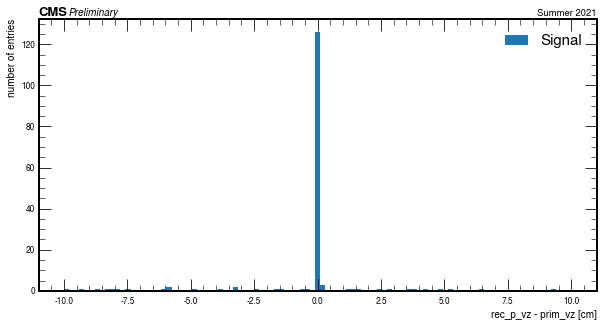

In [138]:
#1. vertex in space: z(muonsvtx) =  (t_p1 - t_p2)* c/2
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns

#p1 has pos index -> pz > 0
#pr_t = evt_t0 + (zpps - sgn(pr_z)*pr_vz) / c
p1_t = sig['pr1_t']
p2_t = sig['pr2_t'] 

mu_vz = - (p1_t - p2_t)*c/2 
vz_4D = sig['pr_vtx_z']

#then we use the formula for Deltat to obtain the di-proton vertex, and then we compare it to vtx4D_z[0]

val = mu_vz - vz_4D
print(len(val))
bins = np.linspace(-10,10,100)
#print(val)
f, ax = plt.subplots(figsize=(10,5))
plt.hist(val, bins,label='Signal')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(fontsize = 15); 
ax.set(xlabel=r'rec_p_vz - prim_vz [cm]', ylabel='number of entries')
#plt.xlim(-0.6,0.6)
plt.savefig('Week7/mu_4D_vz_diff.png',bbox_inches='tight')

167


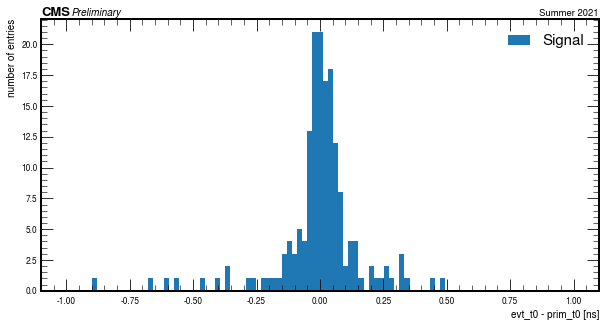

In [171]:
data = sig['evt_t0'].values - sig['pr_vtx_t'].values
print(len(data))
bins = np.linspace(-1,1,100)
#print(val)
f, ax = plt.subplots(figsize=(10,5))
plt.hist(data, bins,label='Signal')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(fontsize=15); 
ax.set(xlabel=r'evt_t0 - prim_t0 [ns]', ylabel='number of entries')

plt.savefig('Week7/evt_4D_vt_diff.png',bbox_inches='tight')

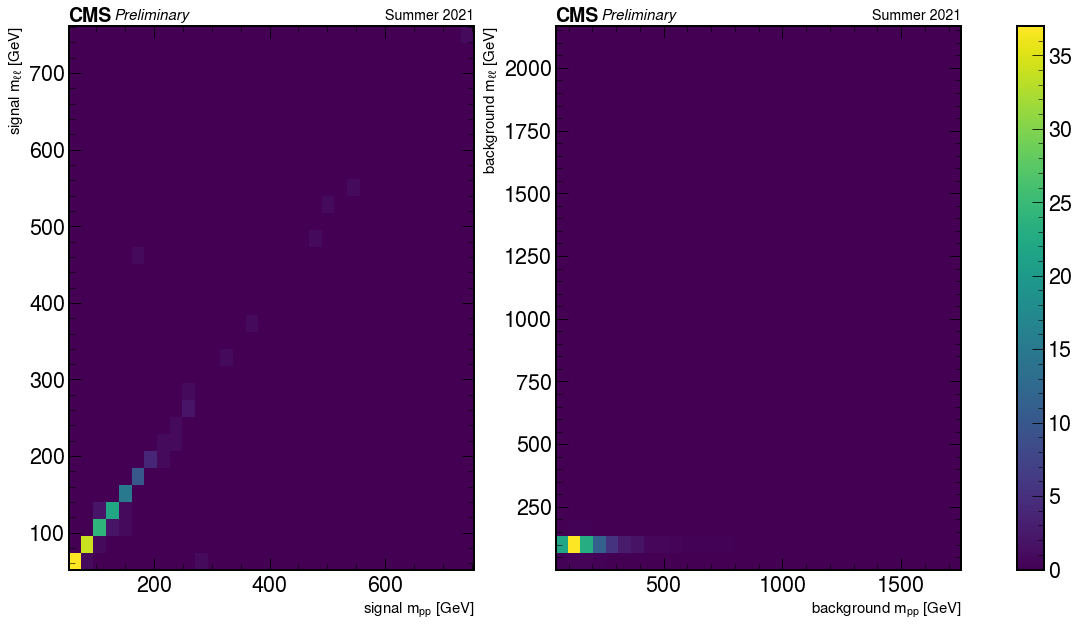

In [11]:
#plot mpp vs mll for pile-up and signal pairs.

fig, axes = plt.subplots(1,2,figsize=(20,10) )
proton = sig['mpp'].values
muon = sig['mll'].values
#print(len(analysis['s_mpp'].values))
h1 = axes[0].hist2d(sig['mpp'].values, sig['mll'].values, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal $m_{pp}$ [GeV]', ylabel=r'signal $m_{\ell \ell}$ [GeV]')
#axes[0].set_ylim(50,500)
#axes[0].set_xlim(50,500)
h2 = axes[1].hist2d(bg['mpp'].values, bg['mll'].values, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'background $m_{pp}$ [GeV]', ylabel=r'background $m_{\ell \ell}$ [GeV]')
#axes[1].set_ylim(0,800)
#axes[1].set_xlim(0,800)
fig.colorbar(h1[3], ax=axes)
for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i], fontsize = 15)
    #axes[i].legend(fontsize=10)
    axes[i].xaxis.label.set_size(15)
    axes[i].yaxis.label.set_size(15)
plt.savefig('Week7/mpp_mll.png')

[Text(1, 59.0, '|Y|'), Text(58.5, 1, 'number of entries')]

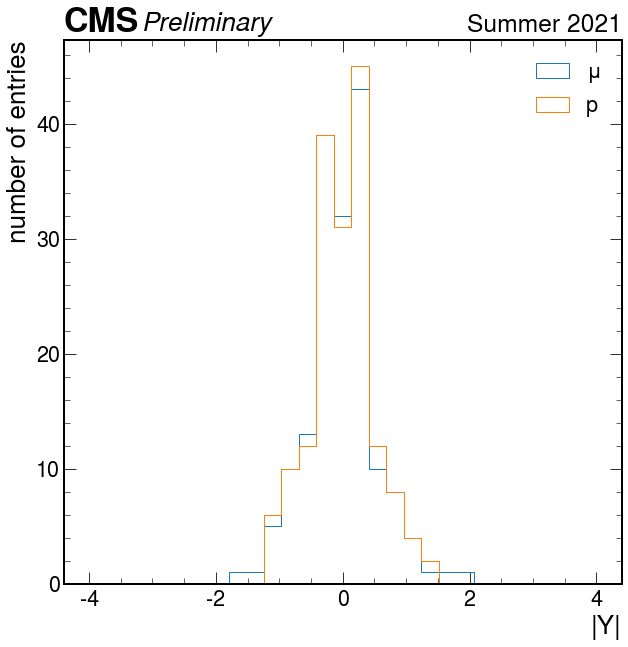

In [12]:
mu_eta = sig['yll'].values
pp_eta = sig['ypp'].values
f, ax = plt.subplots()

bins = np.linspace(-4,4,30)
plt.hist(mu_eta,bins,histtype='step',label = '$\mu$',density = False)
plt.hist(pp_eta, bins, histtype='step',label ='p', density=False)
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend() 
ax.set(xlabel='|Y|', ylabel='number of entries')
#plt.savefig('Week7/rapidity.png')

[Text(1, 14.0, 'rec_y - mu_y'), Text(46.5, 1, 'number of entries')]

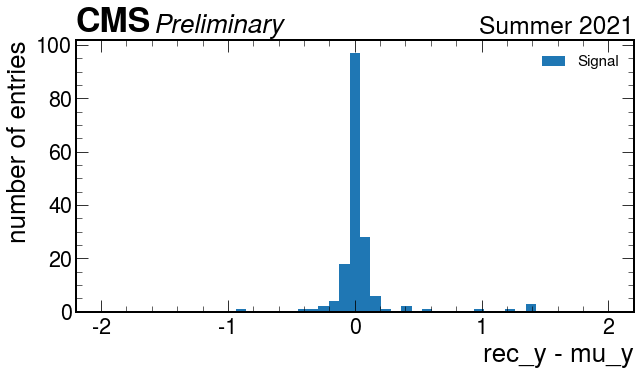

In [13]:
val = (pp_eta - mu_eta)/abs(mu_eta)
#print(val)
#print(pp_eta)
#print(mu_eta)
bins = np.linspace(-2,2,50)
#print(val)
f, ax = plt.subplots(figsize=(10,5))
plt.hist(val, bins,label='Signal')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(fontsize=15); 
ax.set(xlabel=r'rec_y - mu_y', ylabel='number of entries')

#plt.xlim(-0.6,0.6)
#plt.savefig('Week7/eta_diff.png',bbox_inches='tight')

In [ ]:
data = bg['evt_t0'].values - bg['pr_vtx_t'].values
print(len(data))
bins = np.linspace(-0.2,0.2,100)
#print(val)
f, ax = plt.subplots(figsize=(10,5))
plt.hist(data, bins,label='Background')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(fontsize=15); 
ax.set(xlabel=r'evt_t0 - prim_t0 [ns]', ylabel='number of entries')

plt.savefig('Week7/evt_4D_vt_diff_bg.png',bbox_inches='tight')

In [ ]:
#1. vertex in space: z(muonsvtx) =  (t_p1 - t_p2)* c/2
zpps = 2.34e4 #in cm
c = 29.9792#in cm/ns

#p1 has pos index -> pz > 0
#pr_t = evt_t0 + (zpps - sgn(pr_z)*pr_vz) / c
b_p1_t = bg['pr1_t']
b_p2_t = bg['pr2_t'] 

b_mu_vz = - (b_p1_t - b_p2_t)*c/2 
b_vz_4D = bg['pr_vtx_z']

#then we use the formula for Deltat to obtain the di-proton vertex, and then we compare it to vtx4D_z[0]

val = b_mu_vz - b_vz_4D
print(len(val))
bins = np.linspace(-20,20,100)
#print(val)
f, ax = plt.subplots(figsize=(10,5))
plt.hist(val, bins,label='Background')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(fontsize=15); 
ax.set(xlabel=r'rec_p_vz - prim_vz [cm]', ylabel='number of entries')
#plt.xlim(-0.6,0.6)
plt.savefig('Week7/mu_4D_vz_diff_bg.png',bbox_inches='tight')

In [ ]:
N = len(bg_protons)
print(N)
N_protons = []
for i in range(N):
    N_protons.append(len(bg_protons.genproton_pz[i]))
    
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(N_protons, label='Background protons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='Number of protons in event', ylabel='number of entries')
#plt.savefig('W5/Bg_number_protons_all.png',bbox_inches='tight')

In [ ]:
N = len(bg_muons)
print(N)
N_muons = []
for i in range(N):
    N_muons.append(len(bg_muons.pfcand_pt[i]))
    
#lets draw hisgorgam of number of muons:
f, ax = plt.subplots(figsize=(10,5))
plt.hist(N_muons, bins=np.linspace(0,3.5,40),label='Background muons')
hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax)
ax.legend(); 
ax.set(xlabel='Number of muons in event', ylabel='number of entries')
#plt.savefig('AnalyseW2/Bg_number_muons_signal.png',bbox_inches='tight')

In [ ]:
#print(bg_anal['mpp'].values)
f, ax = plt.subplots(1,2,figsize=(20,5),sharey=False)
ax[0].hist(np.concatenate([bg['mu1_eta'].values,bg['mu2_eta'].values]),bins=np.linspace(-4,4,20), label='Background muons')
ax[0].set(xlabel=r'$|Y|$ of muons', ylabel='number of entries')
#ax[0].set_ylim(0,1200)

ax[1].hist(bg['mll'].values, bins=np.linspace(0,150,150),label='Background muons')
ax[1].set(xlabel=r'$m_{\ell\ell}$ [GeV]')
ax[1].set_xlim(0,150)
for i in range(2):
    hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=ax[i])
    ax[i].legend()
#plt.savefig('AnalyseW2/bg_dimuon_analysis_corrected.png',bbox_inches='tight')

In [ ]:
#plot mpp vs mll for pile-up and signal pairs.

fig, axes = plt.subplots(1,2,figsize=(18,10) )
proton = analysis['s_mpp'].values
muon = analysis['s_mll'].values

b_proton = bg_anal['mpp'].values
b_muon = bg_anal['mll'].values

print(len(b_muon))
print(len(muon))

h = axes[0].hist2d(proton, muon, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal $m_{pp}$ [GeV]', ylabel=r'signal $m_{\ell \ell}$ [GeV]')
#axes[0].set_ylim(50,500)
#axes[0].set_xlim(50,500)
axes[1].hist2d(b_proton, b_muon, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'background $m_{pp}$ [GeV]', ylabel=r'background $m_{\ell \ell}$ [GeV]')
axes[1].set_ylim(0,700)
fig.colorbar(h[3], ax=axes)
#plt.ylim(0,250)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

#plt.savefig('AnalyseW2/corr_mpp_mll_sig_bg')

In [ ]:
#plot mpp vs mll for pile-up and signal pairs.

fig, axes = plt.subplots(1,2,figsize=(18,10) )
proton = analysis['s_mpp'].values
muon = analysis['s_mll'].values

b_proton = bg_anal['mpp'].values
b_muon = bg_anal['mll'].values

print(len(b_muon))
print(len(muon))
m = []
for i in range(0,64):
    m = np.append(m,b_muon[i])
print(len(m))
h = axes[0].hist2d(proton, muon, bins=(32,32) , cmap='viridis')
axes[0].set(xlabel=r'signal $m_{pp}$ [GeV]', ylabel=r'signal $m_{\ell \ell}$ [GeV]')
#axes[0].set_ylim(50,500)
#axes[0].set_xlim(50,500)
axes[1].hist2d(muon, m, bins=(32,32) , cmap='viridis')
axes[1].set(xlabel=r'signal $m_{\ell \ell}$ [GeV]', ylabel=r'background $m_{\ell \ell}$ [GeV]')
#axes[1].set_ylim(0,200)
fig.colorbar(h[3], ax=axes)
#plt.ylim(0,250)
for i in range(2): hep.cms.label(llabel="Preliminary", rlabel="Summer 2021", ax=axes[i])

#plt.savefig('AnalyseW2/corr_mpp_mll_sig_bg_corre')